In [1]:
import json
import requests
import re
from datetime import datetime

import pandas as pd
import numpy as np
import time

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score

import pickle
import math

In [2]:
BASE_URL = 'https://api.opendota.com/api/'
TEAMS = 'teams'
HEROES = 'heroes'
PROPLAYERS = 'proPlayers'
PROMATCHES = 'proMatches'
MATCHES = 'matches'
PLAYERS = 'players'
HEROES_STATS = 'heroStats'

In [123]:
# read team OG matches file
with open(r'C:\Users\johnp\deploy-mlmodel\MachineLearningWebApp\deploy-mlmodel-project\data\royal_never_give_up_data.json', 'r', encoding="utf-8") as input_file:

    data = input_file.read()
    royal_never_give_up_matches_json = json.loads(data)

In [4]:
def match_outcome(radiant_win, radiant):
    if ((radiant_win == False and radiant == False) or (radiant_win == True and radiant == True)):
        return True
    
    elif ((radiant_win == True and radiant == False) or (radiant_win == False and radiant == True)):
        return False

In [69]:
error_list = []

def process_data(team_matches_json):

    for index, item in enumerate(team_matches_json):

        predict_players_mmr_total = 0
        predict_players_mmr_count = 0
        for x, i in enumerate(item['predict_players']):

            try:
                predict_players_mmr_total += i['player_stats']['mmr_estimate']['estimate']
                predict_players_mmr_count += 1

            except:

                error_list.append(index)
                
        # get the average MMR of the team
        try:
            team_matches_json[index]['predict_players_mmr_average'] = predict_players_mmr_total / predict_players_mmr_count
            
        except:
            team_matches_json[index]['predict_players_mmr_average'] = None
            error_list.append(index)

        opposing_players_mmr_total = 0
        opposing_players_mmr_count = 0
        for y, j in enumerate(item['opposing_players']):

            try:
                opposing_players_mmr_total += j['player_stats']['mmr_estimate']['estimate']
                opposing_players_mmr_count += 1

            except:

                error_list.append(index)
        
        try:
            team_matches_json[index]['opposing_players_mmr_average'] = opposing_players_mmr_total / opposing_players_mmr_count
        
        except:
            team_matches_json[index]['opposing_players_mmr_average'] = None
            error_list.append(index)
        
        
        predict_team_total_matches = item['predict_team_stat'][0]['predict_team_wins_total'] + item['predict_team_stat'][0]['predict_team_losses_total']
        team_matches_json[index]['predict_team_total_matches'] = predict_team_total_matches
        
        predict_team_win_pct = round(item['predict_team_stat'][0]['predict_team_wins_total'] / predict_team_total_matches * 100, 2)
        team_matches_json[index]['predict_team_win_pct'] = predict_team_win_pct
        
        try:
            opposing_team_total_matches = item['opposing_team_stat'][0]['opposing_team_wins_total'] + item['opposing_team_stat'][0]['opposing_team_losses_total']
        
        except:
            error_list.append(index)
            opposing_team_total_matches = 0


        team_matches_json[index]['opposing_team_total_matches'] = opposing_team_total_matches 
        
        try:
            opposing_team_win_pct =  round(item['opposing_team_stat'][0]['opposing_team_wins_total'] / opposing_team_total_matches * 100, 2)
        except:
            error_list.append(index)
            opposing_team_win_pct = 0

        team_matches_json[index]['opposing_team_win_pct'] = opposing_team_win_pct

In [124]:
process_data(royal_never_give_up_matches_json)


In [8]:
def get_predict_data(predict_team_dict, opposing_team_dict):

    predict_players_mmr_total = 0
    predict_players_mmr_count = 0
    opposing_players_mmr_total = 0
    opposing_players_mmr_count = 0

    for x, i in enumerate(predict_team_dict['predict_players']):

        try:
            predict_players_mmr_total += i['player_stats']['mmr_estimate']['estimate']
            predict_players_mmr_count += 1

        except:

            error_list.append()
            
    # get the average MMR of the predict team
    predict_players_mmr_average = predict_players_mmr_total / predict_players_mmr_count

    predict_team_total_matches = predict_team_dict['predict_team_stat'][0]['predict_team_wins_total'] + predict_team_dict['predict_team_stat'][0]['predict_team_losses_total']
    
    predict_team_win_pct = round(predict_team_dict['predict_team_stat'][0]['predict_team_wins_total'] / predict_team_total_matches * 100, 2)
    
    for y, j in enumerate(opposing_team_dict['predict_players']):

        try:
            opposing_players_mmr_total += i['player_stats']['mmr_estimate']['estimate']
            opposing_players_mmr_count += 1

        except:

            error_list.append()
    
    # get the average MMR of the opposing team
    opposing_players_mmr_average = opposing_players_mmr_total / opposing_players_mmr_count

    opposing_team_total_matches = opposing_team_dict['predict_team_stat'][0]['predict_team_wins_total'] + opposing_team_dict['predict_team_stat'][0]['predict_team_losses_total']

    opposing_team_win_pct = round(opposing_team_dict['predict_team_stat'][0]['predict_team_wins_total'] / opposing_team_total_matches * 100, 2)

    predict_data_df =  pd.DataFrame(data = {'predict_team_total_matches' : predict_team_total_matches, 
                                            'predict_team_win_pct' : predict_team_win_pct, 
                                            'predict_team_rating' : predict_team_dict['predict_team_stat'][0]['predict_team_rating'], 
                                            'predict_players_mmr_average' : predict_players_mmr_average, 
                                            'opposing_team_total_matches' : opposing_team_total_matches, 
                                            'opposing_team_win_pct' : opposing_team_win_pct, 
                                            'opposing_team_rating' : opposing_team_dict['predict_team_stat'][0]['predict_team_rating'], 
                                            'opposing_players_mmr_average' : opposing_players_mmr_average}, 
                                            index = [0])     

    return predict_data_df           

In [58]:
tundra_esports_profile_df = get_predict_data(tundra_esports_matches_json[0], team_secret_matches_json[0])

In [9]:
# Convert the team matches json to a dataframe
def team_matches_df(team_matches_json, predict_team_name, predict_team_id):
    
    all_matches_df = pd.DataFrame(data = [(datetime.fromtimestamp(item['start_time']).strftime('%Y-%m-%d %H:%M:%S'),
                                                       predict_team_name,
                                                       predict_team_id,
                                                       item['predict_team_total_matches'],
                                                       item['predict_team_win_pct'],
                                                       item['predict_team_stat'][0]['predict_team_rating'],
                                                       item['predict_players_mmr_average'],
                                                       item['opposing_team_name'],
                                                       item['opposing_team_id'],
                                                       item['opposing_team_total_matches'],
                                                       item['opposing_team_win_pct'],
                                                       item['opposing_team_stat'][0]['opposing_team_rating'],
                                                       item['opposing_players_mmr_average'],
                                                       item['league_name'],
                                                       item['leagueid'],
                                                       item['cluster'], 
                                                       item['radiant_win'],
                                                       item['radiant'],
                                                       item['duration'], 
                                                       item['match_id'],
                                                       match_outcome(item['radiant_win'], item['radiant'])) for index, item in enumerate(team_matches_json)], 
                      columns = ['start_date', 
                                 'predict_team_name', 
                                 'predict_team_id', 
                                 'predict_team_total_matches', 
                                 'predict_team_win_pct',
                                 'predict_team_rating',   
                                 'predict_players_mmr_average', 
                                 'opposing_team_name', 
                                 'opposing_team_id', 
                                 'opposing_team_total_matches',
                                 'opposing_team_win_pct', 
                                 'opposing_team_rating',
                                 'opposing_players_mmr_average', 
                                 'league_name', 
                                 'leagueid', 
                                 'cluster', 
                                 'radiant_win', 
                                 'radiant', 
                                 'duration', 
                                 'match_id', 
                                 'match_outcome'])
    
    return all_matches_df


In [125]:
royal_never_give_up_matches_df = team_matches_df(royal_never_give_up_matches_json, 'royal_never_give_up', 6209804)

In [26]:
entity_matches_df.shape

(208, 21)

In [12]:
fnatic_matches_df.head()

,start_date,predict_team_name,predict_team_id,predict_team_total_matches,predict_team_win_pct,predict_team_rating,predict_players_mmr_average,opposing_team_name,opposing_team_id,opposing_team_total_matches,...,opposing_team_rating,opposing_players_mmr_average,league_name,leagueid,cluster,radiant_win,radiant,duration,match_id,match_outcome
0,2022-10-18 14:13:38,fnatic,350190,2034,57.62,1359.85,7151.0,Tundra Esports,8291895,255,...,1486.24,7715.6,The International 2022,14268,154,False,True,2377,6810862848,False
1,2022-10-18 13:02:50,fnatic,350190,2034,57.62,1359.85,7151.0,Tundra Esports,8291895,255,...,1486.24,7715.6,The International 2022,14268,154,False,True,2268,6810818538,False
2,2022-10-17 21:06:03,fnatic,350190,2034,57.62,1359.85,7151.0,Talon,8597976,165,...,1360.28,7070.0,The International 2022,14268,154,False,True,2405,6809742301,False
3,2022-10-17 19:39:13,fnatic,350190,2034,57.62,1359.85,7151.0,Talon,8597976,165,...,1360.28,7070.0,The International 2022,14268,154,False,True,3397,6809665094,False
4,2022-10-17 16:56:55,fnatic,350190,2034,57.62,1359.85,7151.0,Team Aster,6209166,919,...,1456.06,7333.8,The International 2022,14268,154,True,True,3947,6809556554,True


In [23]:
team_secret_matches_df.dropna(inplace=True)

In [24]:
team_secret_matches_df.shape

(1543, 21)

In [15]:
fnatic_matches_df.describe()

,predict_team_id,predict_team_total_matches,predict_team_win_pct,predict_team_rating,predict_players_mmr_average,opposing_team_id,opposing_team_total_matches,opposing_team_win_pct,opposing_team_rating,opposing_players_mmr_average,leagueid,cluster,duration,match_id
count,2110.0,2110.0,2.110000e+03,2110.00,2110.000000,2.110000e+03,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000,2.110000e+03
mean,350190.0,2034.0,5.762000e+01,1359.85,7049.334905,2.645015e+06,968.313270,53.963986,1210.112201,6487.437970,6997.437915,147.270616,2245.443128,2.978957e+09
std,0.0,0.0,7.107112e-15,0.00,286.241801,2.872549e+06,811.692135,8.078025,163.627356,598.985284,8201.663386,27.319514,679.278327,2.172003e+09
min,350190.0,2034.0,5.762000e+01,1359.85,5640.800000,2.000000e+00,1.000000,0.000000,784.568000,3791.333333,21.000000,111.000000,442.000000,1.254870e+08
25%,350190.0,2034.0,5.762000e+01,1359.85,6975.800000,1.114740e+05,262.750000,51.540000,1086.200000,6145.800000,1123.000000,132.000000,1796.750000,6.279829e+08
50%,350190.0,2034.0,5.762000e+01,1359.85,7150.500000,1.842972e+06,627.000000,55.540000,1166.030000,6511.600000,5313.000000,151.000000,2168.000000,2.935758e+09
75%,350190.0,2034.0,5.762000e+01,1359.85,7304.000000,3.903083e+06,1933.000000,57.860000,1299.160000,6945.200000,11280.000000,154.000000,2627.500000,4.971621e+09
max,350190.0,2034.0,5.762000e+01,1359.85,7422.750000,8.724984e+06,2508.000000,81.250000,1560.220000,7715.600000,65013.000000,308.000000,5867.000000,6.810863e+09


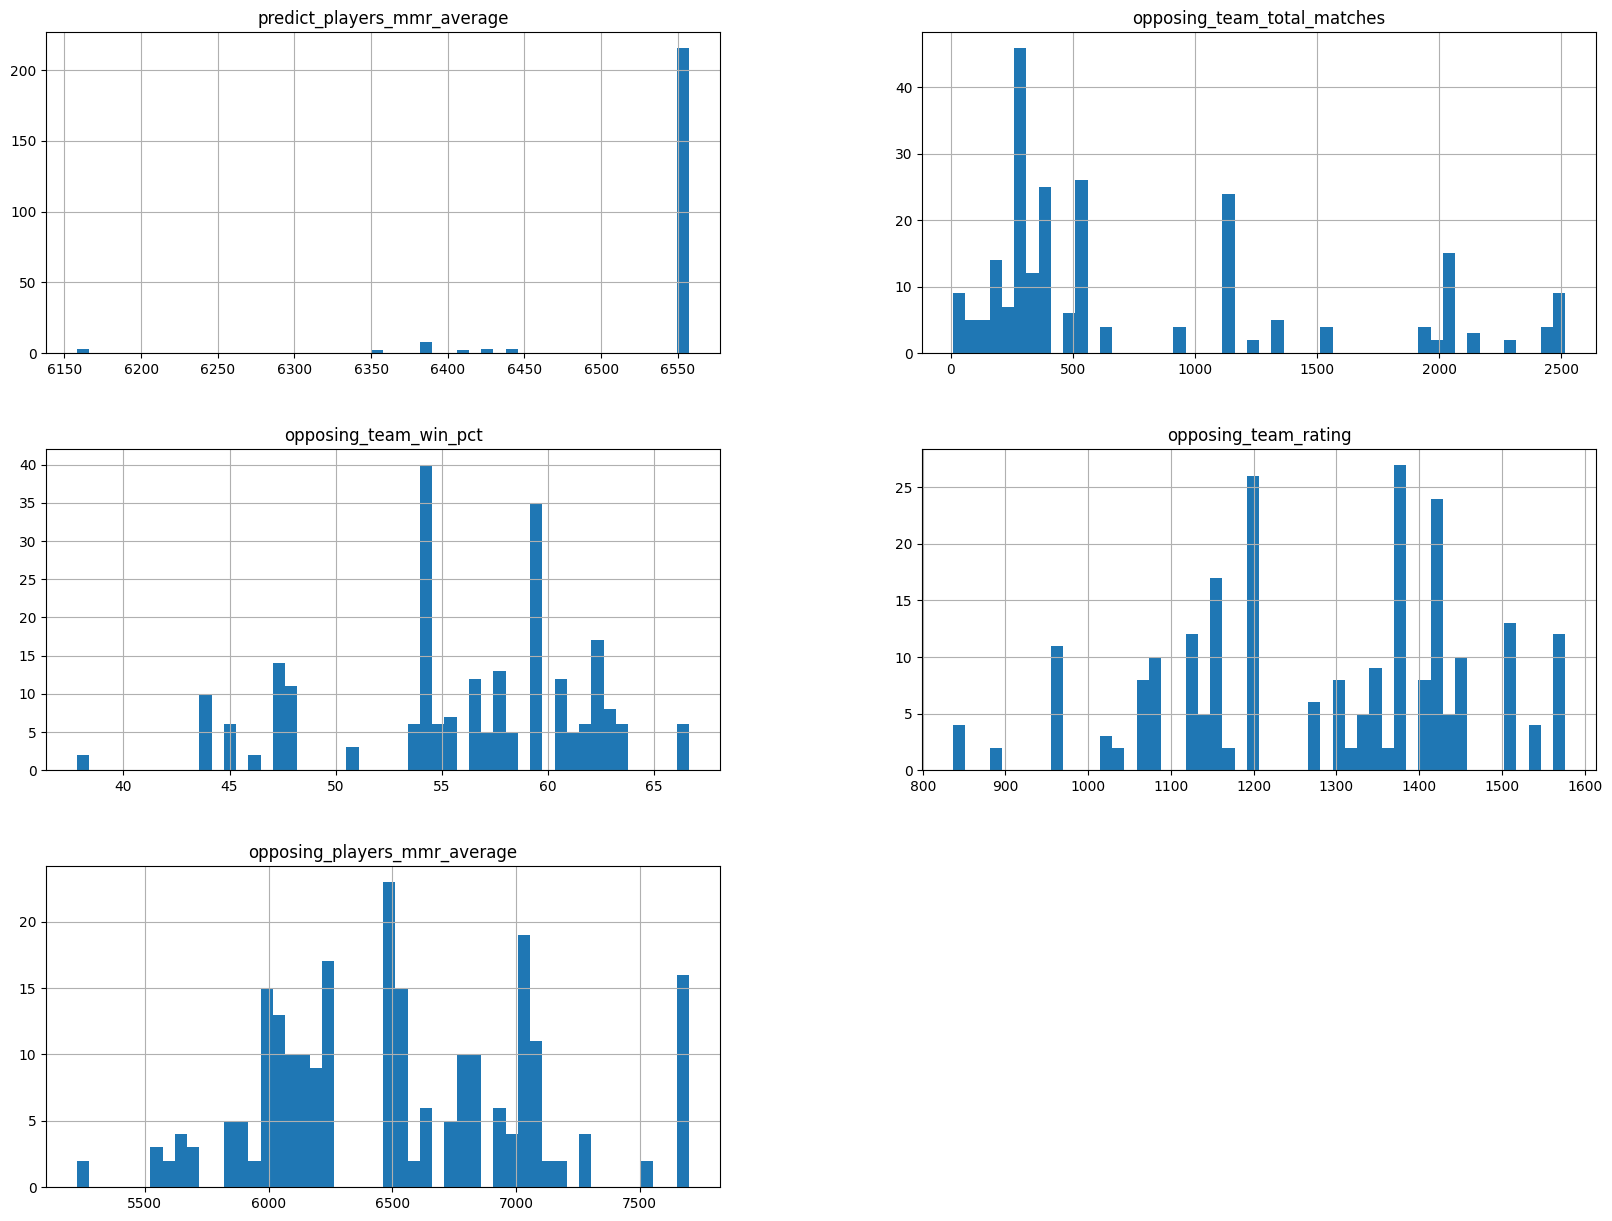

In [34]:
beastcoast_matches_df.loc[:,['predict_players_mmr_average', 
                   'opposing_team_total_matches', 
                   'opposing_team_win_pct', 
                   'opposing_team_rating', 
                   'opposing_players_mmr_average']].hist(bins = 50, figsize=(20, 15))
plt.show()

In [126]:
X = royal_never_give_up_matches_df.drop(labels = ['match_outcome', 
                                      'start_date', 
                                      'predict_team_name',
                                      'predict_team_id',
                                      'opposing_team_name',
                                      'opposing_team_id',
                                      'league_name',
                                      'leagueid',
                                      'cluster', 
                                      'radiant_win', 
                                      'radiant', 
                                      'match_id', 
                                      'duration'], axis = 1)

y = royal_never_give_up_matches_df.match_outcome

# Consider scaling the data (Normalisation or Standardisation)

In [127]:
X.head()

,predict_team_total_matches,predict_team_win_pct,predict_team_rating,predict_players_mmr_average,opposing_team_total_matches,opposing_team_win_pct,opposing_team_rating,opposing_players_mmr_average
0,929,58.13,1411.47,7316.4,208,62.02,1421.58,6712.2
1,929,58.13,1411.47,7316.4,1350,61.41,1439.16,6036.0
2,929,58.13,1411.47,7316.4,1350,61.41,1439.16,6036.0
3,929,58.13,1411.47,7316.4,2024,62.10,1413.61,7663.0
4,929,58.13,1411.47,7316.4,2024,62.10,1413.61,7663.0


In [128]:
X.columns

Index(['predict_team_total_matches', 'predict_team_win_pct',
       'predict_team_rating', 'predict_players_mmr_average',
       'opposing_team_total_matches', 'opposing_team_win_pct',
       'opposing_team_rating', 'opposing_players_mmr_average'],
      dtype='object')

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [130]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

In [131]:
y_pred = log_reg.predict(X_test)

In [132]:
conf_mtx = confusion_matrix(y_test, y_pred)

In [133]:
conf_mtx

array([[34, 48],
       [24, 69]], dtype=int64)

# Explanation

[[True Negative, False Positive],

 [False Negative, True Positive]]
 
In the first row, the model CORRECTLY predicted 40 losses, but INCORRECTLY predicted 54 wins (it should have been losses)

In the second row, the model INCORRECTLY predicted 28 losses (it should have been wins), while it CORRECTLY predicted 145 wins
 


In [134]:
precision_score(y_test, y_pred)

0.5897435897435898

The Logistic Regression model can CORRECTLY predict WINS 71.77% of the time

In [135]:
recall_score(y_test, y_pred)

0.7419354838709677

Save the Logistic Regression as a Pickle File

In [136]:
pickle.dump(log_reg, open('royal_never_give_up_log_reg.pkl', 'wb'))

In [30]:
X_test[0:5]

,predict_team_total_matches,predict_team_win_pct,predict_team_rating,predict_players_mmr_average,opposing_team_total_matches,opposing_team_win_pct,opposing_team_rating,opposing_players_mmr_average
115,239,55.23,1447.04,6557.6,1157,54.02,1198.46,6161.8
15,239,55.23,1447.04,6557.6,927,55.02,1504.82,7289.6
211,239,55.23,1447.04,6557.6,1157,54.02,1198.46,6179.2
126,239,55.23,1447.04,6557.6,277,59.21,1420.20,6464.2
6,239,55.23,1447.04,6557.6,277,59.21,1420.20,6559.8


In [31]:
y_test[0:5]

497    False
244    False
552    False
213     True
549    False
Name: match_outcome, dtype: bool

In [32]:
y_pred[0:5]

array([ True,  True,  True,  True, False])

In [33]:
X_test.iloc[1, :]

predict_team_total_matches       629.00
predict_team_win_pct              60.73
predict_team_rating             1375.73
predict_players_mmr_average     6797.20
opposing_team_total_matches      370.00
opposing_team_win_pct             57.03
opposing_team_rating            1279.66
opposing_players_mmr_average    7056.40
Name: 244, dtype: float64

In [ ]:
test_list = []
for item in X_test.iloc[1, :]:
    test_list.append(item)

In [ ]:
log_reg.predict([test_list])

c:\Users\johnp\deploy-mlmodel\deploy-mlmodel-env\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


array([ True])

In [ ]:
number = 12345

In [ ]:
print(f'number is: {number}')

number is: 12345


In [ ]:
predict_team = {'1838315' : 'Team Secret', 
                    '2586976' : 'OG', 
                    '2163' : 'Team Liquid', 
                    '7732977' : 'Boom Esports', 
                    '15' : 'PSG.LGD', 
                    '7119388' : 'Team Spirit', 
                    '8254400' : 'Beastcoast', 
                    '6209166' : 'Team Aster', 
                    '7391077' : 'Thunder Awaken', 
                    '8260983' : 'TSM', 
                    '8291895' : 'Tundra Esports', 
                    '7390454' : 'Soniqs', 
                    '8599101' : 'Gaimin Gladiators', 
                    '39' : 'Evil Geniuses', 
                    '350190' : 'Fnatic', 
                    '8131728' : 'Hokori', 
                    '8605863' : 'Entity', 
                    '8721219' : 'BetBoom Team', 
                    '6209804' : 'Royal Never Give Up', 
                    '8597976' : 'Talon Esports'} 

In [ ]:
for key, value in predict_team.items():
    print(key, value)

1838315 Team Secret
2586976 OG
2163 Team Liquid
7732977 Boom Esports
15 PSG.LGD
7119388 Team Spirit
8254400 Beastcoast
6209166 Team Aster
7391077 Thunder Awaken
8260983 TSM
8291895 Tundra Esports
7390454 Soniqs
8599101 Gaimin Gladiators
39 Evil Geniuses
350190 Fnatic
8131728 Hokori
8605863 Entity
8721219 BetBoom Team
6209804 Royal Never Give Up
8597976 Talon Esports
